# Example analysis using genulens

                                                                                                                                      by Naoki Koshimoto on July, 2022

This notebook provides some practical event analysis using `genulens`.  
Most commands are repeated from [Usage.pdf](https://github.com/nkoshimoto/genulens/blob/main/Usage.pdf), but this notebook provides them on individual event analysis basis rather than each genulens option basis.  
See section 3 of [Usage.pdf](https://github.com/nkoshimoto/genulens/blob/main/Usage.pdf) for details of each parameter in the arguments used in the commands presented below.  

Before running this, make sure that genulens is compiled under your environment and put in the directrory in which the input_files/ directory is located. This notebook is also assumed to be conducted in a directory where genulens is put.

Note that I'm kind of a new python user and there's a good chance that I'm doing something strange or uncommon.


In [1]:
import numpy as np
import subprocess
from subprocess import PIPE
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# To run genulens through python

def get_header (command) :
    VERBOSITY, BINARY = 0, 0
    args = command.split()
    for i, arg in enumerate(args) :
        if arg == 'VERBOSITY' :
            VERBOSITY = int(args[i+1])
        if arg == 'BINARY' :
            BINARY = int(args[i+1])


    if VERBOSITY == 3 :
        header = 'wtj M_L D_L D_S t_E theta_E pi_E pi_EN pi_EE mu_rel mu_Sl mu_Sb I_L K_L iS iL fREM'.split()
    elif VERBOSITY == 2 :
        header = 'wtj t_E theta_E pi_EN pi_EE D_S mu_Sl mu_Sb iS iL fREM'.split()
    else :
        header = None
    if BINARY == 1 and VERBOSITY > 1 :
        header += 'q21         M2         aL     aLpmin         u0 BL'.split()
    return header
    
def run_genulens (file, argv, ranseed = False, grep = False) :
    command = './genulens ' + argv 
    if ranseed :
        command += ' seed {}'.format(np.random.randint(1e+10))
    if grep:
        command += ' |grep {}'.format(grep)
    command += ' > {}'.format(file)
    print("# Conducted command (you can do this directly in your command line too): ")
    print("\n", command, "\n")
    subprocess.run(command, shell=True, text=True)
    return get_header(command)
    
    
def show_header (file, line1 = 30, line2 = 43) :
    command = "sed -n {},{}p {}".format(line1, line2, file)
    proc = subprocess.run(command, shell=True, stdout=PIPE, stderr=PIPE, text=True)
   # print("# Conducted command (you can do this directly in your command line too): ")
    print("\n", command, "\n")
    print(proc.stdout)

In [3]:
# To print the output 

def weighted_percentile(values, percentiles, weights=None, sw_sort=True, C= 0.5):                                                  
    """                                                                                                                            
    Get percentiles of unequal array
    Reference: 
    https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
    See                                                                                                                            
    https://en.wikipedia.org/wiki/Percentile#The_weighted_percentile_method                                                        
    about the constant C that takes 0, 0.5 or 1                                                                                    
    """                                                                                                                            
    values = np.array(values)                                                                                                      
    percentiles = np.array(percentiles)                                                                                            
    if weights is None:                                                                                                            
        weights = np.ones(len(values))                                                                                             
    weights = np.array(weights)                                                                                                    
    assert np.all(percentiles >= 0) and np.all(percentiles <= 1), \
            'percentiles should be in [0, 1]'                                                                                      
    assert C==0 or C==0.5 or C==1, \
            'C should be 0, 0.5 or 1'                                                                                              
                                                                                                                                   
    if sw_sort:                                                                                                                    
        sorter = np.argsort(values)                                                                                                
        values = values[sorter]                                                                                                    
        weights = weights[sorter]                                                                                                  
                                                                                                                                   
    cumu_wts = np.cumsum(weights)                                                                                                  
    weighted_percentiles = (cumu_wts - C * weights) / (cumu_wts[-1] + (1-2*C)*weights)                                             
    return np.interp(percentiles, weighted_percentiles, values)                                                                    


def plot_hist_wt (axis, data, col = 'C1', log = 0, label = None, wt = None, NXBIN = 50) :
    xmin, xmax = weighted_percentile(data, [0.001, 0.999], weights=wt)
    if(log == 1) :
        xbins = np.logspace(np.log10(xmin), np.log10(xmax), num=NXBIN+1)
    else :
        xbins = np.linspace(xmin, xmax, num=NXBIN+1)
    y, x, pol = axis.hist(data, bins = xbins, histtype = 'step', linewidth = 2, color = col, label = label, weights = wt)
    xpers  = weighted_percentile(data, [0.1587, 0.50, 0.8413], weights=wt)
    # print (xpers)
    # xpers = np.percentile(data, q=100*np.array([0.1587, 0.50, 0.8413]))
    if log == 1 :
        xmids = 0.5 * (np.log10(xbins)[1:] + np.log10(xbins)[0:-1])
        dxpers = np.array([np.abs(xmids - np.log10(xper)) for xper in xpers])
        axis.set_xscale("log")
    else :
        xmids = 0.5 * (xbins[1:] + xbins[0:-1])
        dxpers = np.array([np.abs(xmids - xper) for xper in xpers])
    ix_pers = dxpers.argmin(1) 
    lss = ['--', '-', '--']
    for i, xeach in enumerate(xpers) :
        yeach = y[ix_pers[i]]
        axis.vlines(xeach, 0, yeach, ls = lss[i], color = col)
    return xpers
        
        
def print_data (file, header, DISP = True, usecols = None) :
    # Read the list
    data = np.loadtxt(file, usecols = usecols)
    if (DISP) :
        dataset = pd.DataFrame(data, columns=header)
        display(dataset)
        print("Unweighted statistics (just for reference) : ")
        display(dataset.describe())
    return data

def hist_wt (data, header, logparams = [], wtcol = None, PLOT = True, NXBIN = 50) :
    nparam = data.shape[1]
    dataT = data.T
    # Set wt array
    if wtcol is None :
        wt = np.ones(data.shape[0])
        wtcol = nparam + 1 # set non-exist column 
    else :
        wt =  dataT[wtcol]

    if PLOT:  # plot histogram
        if wtcol < nparam :
            print("Histogram weighted by ", header[wtcol], " : ")
        plt.rcParams["font.size"] = 13
        
        # Determine number of panels
        Nx = int(np.sqrt(nparam))
        if(Nx != np.sqrt(nparam)) : Nx += 1
        Ny = int(nparam / Nx)
        if(Nx * Ny < nparam) : Ny += 1

        fig, ax = plt.subplots(Ny, Nx, figsize=(14, 14*Ny/Nx))
        plt.subplots_adjust(wspace=0.4, hspace=0.4)


        for i in range(Ny*Nx) :
            # Skip wtcol param
            if i == wtcol : 
                continue

            # Get (ix, iy)
            if i < wtcol :
                ix = int(i/Nx)
                iy = i % Nx
            else :
                ix = int((i-1)/Nx)
                iy = (i-1) % Nx
                if i == Ny*Nx - 1 :
                    ax[int(i/Nx), i % Nx].axis('off') # deactivate the panel unused due to wtcol

            if i >= nparam :
                ax[ix,iy].axis('off')
                continue

            if (header[i] in logparams) :
                LOG = 1
            else :
                LOG = 0

            # print(header[i])
            plot_hist_wt(ax[ix, iy], dataT[i], col = 'C0', log = LOG, wt = wt, NXBIN = NXBIN)
            if iy == 0 : 
                ax[ix,iy].set_ylabel(r'Number', fontsize = 16)
            ax[ix,iy].set_xlabel('{}'.format(header[i]), fontsize = 16)
            # ax[ix,iy].legend(fontsize = 18, loc='upper left')


    # percentiles = np.array([weighted_percentile(dataT[i], [0.0228, 0.1587, 0.50, 0.8413, 0.9772], weights=wt) for i in range(nparam)])
    percentiles = np.zeros([nparam, 5])
    for i in range(nparam) :
        if i == wtcol : continue
        percentiles[i] = weighted_percentile(dataT[i], [0.0228, 0.1587, 0.50, 0.8413, 0.9772], weights=wt)
    
    return percentiles


## Sample 1. Posterior distribution of the lens mass and distance for a planetary event
In [Koshimoto et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...788..128K/abstract), $t_E = 34.0 \pm 2.2$ days and $\theta_E = 0.28 \pm 0.03$ mas are measured for OGLE-2008-BLG-355 occurred at $(l, b) = (-0.08, -3.45)$ deg.  
They also put a lower limit on the lens magnitude (upper limit on the lens brightness), $I_L > 20.67 \pm 0.47$ mag (this estimation of error looks suspicious to me now, eight years later, but let's respectfully use it as it was then...).  
Let's calculate the posterior distribution of the lens mass and distance for this event using `genulens` .   
To put the $I_L$ constraint[^1](#1), the extinction for the red clump, $A_I = 1.63$, is needed.  

<span id="1" style="font-size:small">1: 
Note on the $I_L$ constraint :  
The likelihood is calculated using the normal distribution with the magnitude unit, i.e., $\exp[-0.5(I_L - I_{L, obs})^2/I_{L, err}^2]$. This could be appropriate if the error is dominated by the calibration error.  If the error is dominated by the photon noise, it should be calculated in flux unit, which is not currently supported by `genulens`. Nevertheless, if the error in magnitude is small enough, it works fine because a linear approximation is applicable to the conversion between magnitude and flux.  In the current case of $20.67 \pm 0.47$ mag, the error is large, though. So, this is not appropriate unless the error is dominated by calibration error.
</span>


In [4]:
# I can do the following by one line, like 
# argtxt1 = 'l -0.08 b -3.45 tE 34.0 2.2 thetaE 0.28 0.03 IL 20.67 0.47 ILdet 2 AIrc 1.63 VERBOSITY 3'
# But I divide it into some just to make each option clearer
argtxt1 = ''
argtxt1 += ' l -0.08 b -3.45' # coordinate
argtxt1 += ' tE 34.0 2.2'     #  tE constraint
argtxt1 += ' thetaE 0.28 0.03'  #  thetaE constraint
argtxt1 += ' IL 20.67 0.47 ILdet 2'  #  IL constraint, lower limit
argtxt1 += ' AIrc 1.63'  #  A_I value for red clump. Needed to calculate I_{L,0}
argtxt1 += ' VERBOSITY 3'  # 2 or 3. VERBOSITY controls output parameters

print("Sample 1 argument for genulens : ")
print(argtxt1)

file1 = 'sample1.dat' # output file 

Sample 1 argument for genulens : 
 l -0.08 b -3.45 tE 34.0 2.2 thetaE 0.28 0.03 IL 20.67 0.47 ILdet 2 AIrc 1.63 VERBOSITY 3


### 1.1 Test run with small `NlikeMIN`
Before any possibly long calculation, I recommend doing a test run with a small `NlikeMIN` value to find out how long the calculation would take to have a desired resolution (say, $10^5$ accepted events).  
This time we can expect a relatively short calculation time because the number of observational constraints (i.e., detection of $t_E$ and $\theta_E$ and lower limit of $I_L$) are not many and the values are not uncommon.  
Nevertheless, I'll do a test run with `NlikeMIN` = 10000 for the sake of example.

In [5]:
%%time
# Test run 
NlikeMIN = ' NlikeMIN 10000'
header = run_genulens(file1, argtxt1 + NlikeMIN)

# Conducted command (you can do this directly in your command line too): 

 ./genulens  l -0.08 b -3.45 tE 34.0 2.2 thetaE 0.28 0.03 IL 20.67 0.47 ILdet 2 AIrc 1.63 VERBOSITY 3 NlikeMIN 10000 > sample1.dat 

CPU times: user 1.42 ms, sys: 5.55 ms, total: 6.97 ms
Wall time: 761 ms


This test run takes ~2 secs to have 10000 accepted events. (**Additional note on 2025/3/13: It took ~2 sec on my old laptop, whereas the current wall time is ~0.8 sec. All subsequent time descriptions refer to the results from my old laptop.**)  
Considering ~1 sec overhead for calculations other than the Monte Carlo simulation part, we can expect ~10 secs to have $10^5$ accepted events.  
Because this is acceptable time to me, I will try `NlikeMIN` = 1e+5 run next.  

At this time, it is also recommended to check the header part of the output file (i.e., sample1.dat in this case) to ensure that the intended values are correctly recognized;

In [6]:
# Show line 36 - 53 of sample1.dat.
show_header(file1, 36, 53)


 sed -n 36,53p sample1.dat 

#-------------- Input parameters ---------------
#    CenSgrA= 1     (0: GC at (l,b)=(0,0), 1: GC at (l,b)= (-0.056, -0.046))
#    UNIFORM= 0     (0: L= N(obs, err), 1: L= U(obs-err, obs+err))
#    REMNANT= 0     (0: no remnant, 1: with remnant)
#     onlyWD= 0     (1: w/ remnant but only WD)
#     BINARY= 0     (0: no binary , 1: with binary )
# SMALLGAMMA= 0     (1: output all events even with small Gamma )
#   (Nsimu, NlikeMIN)= (100000, 10000)
#          (l, b, PA)= ( -0.08,  -3.45, 60.28) deg.
#       (vl, vb)Earth= ( 11.94, -17.90) km/s
#     tE = 34.000 +- 2.200 Fe_add=    0.0 det= 0 (0: det, 1: upper limit, 2: lower limit)
# thetaE = 0.280 +- 0.030 Fe_add=    0.0 det= 0 (0: det, 1: upper limit, 2: lower limit)
#      IL = 20.670 +- 0.470 Fe_add=    0.0 det= 2 (0: det, 1: upper limit, 2: lower limit)
#  Consider 14.00 <  Is < 21.00, (hdust, Dmean,  AIrc,  AI0) = (164, 8194, 1.63, 1.71)
# Sampling parameter range : 
#     tErange     : 25.2000 - 42.8

Note that since version 1.2 of `genulens`, only $t_E$ and $\theta_E$ values within the sampling parameter range are simulated for (much) faster simulation.  
When `p [val] [err]` is the constraint (p = tE, thetaE this case), the sampling range is set to be val-c\*err < p < val+c\*err, where c = 1.02 for UNIFORM = 1 while c = 4 for UNIFORM = 0 by default. You can change the constant c using `fIStE [c value]` or `fISthetaE [c value]` option, or omit this new feature using the option `NOIS 1`. (The same run takes ~7 sec with `NOIS 1` )  
In the current case, the sampling parameter ranges are 25.2000 < tE < 42.8000 and 0.1600 < thetaE < 0.4000 according to the header.  

### 1.2 Run with desired `NlikeMIN`

In [7]:
%%time
# run to have the posterior distribution of ML and DL
NlikeMIN = ' NlikeMIN 1e+5'
header = run_genulens(file1, argtxt1 + NlikeMIN) # overwrite file1

# Conducted command (you can do this directly in your command line too): 

 ./genulens  l -0.08 b -3.45 tE 34.0 2.2 thetaE 0.28 0.03 IL 20.67 0.47 ILdet 2 AIrc 1.63 VERBOSITY 3 NlikeMIN 1e+5 > sample1.dat 

CPU times: user 777 μs, sys: 3.09 ms, total: 3.87 ms
Wall time: 5.41 s


This took ~15 secs, which is more or less the expected time.  
Then, let's plot the posterior and determine the lens mass and distance.

,wtj,M_L,D_L,D_S,t_E,theta_E,pi_E,pi_EN,pi_EE,mu_rel,mu_Sl,mu_Sb,I_L,K_L,iS,iL,fREM
0,0.182755,0.367493,7674.0,8806.0,29.91907,0.223936,0.074824,-0.067402,-0.032490,2.733798,-4.02759,0.502332,24.667,99.0,8.0,8.0,0.0
1,0.209647,0.599007,8354.0,9690.0,37.00039,0.283666,0.058149,-0.004866,0.057945,2.800212,-6.99508,-0.329180,23.352,99.0,8.0,8.0,0.0
2,0.029849,0.857063,6444.0,7007.0,31.36112,0.294974,0.042261,-0.034815,0.023956,3.435436,-4.73620,1.336910,20.658,99.0,8.0,8.0,0.0
3,0.199916,0.393112,7946.0,9519.0,27.38180,0.258034,0.080598,0.027461,0.075776,3.441948,-9.22373,2.898030,24.566,99.0,8.0,8.0,0.0
4,0.122139,0.790323,7789.0,8485.0,34.55646,0.260402,0.040458,-0.032035,-0.024710,2.752354,-5.01739,-1.738080,21.595,99.0,8.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100022,0.221850,0.647754,8036.0,9796.0,33.06072,0.343395,0.065095,0.053675,0.036830,3.793775,-5.45730,1.125210,22.666,99.0,8.0,8.0,0.0
100023,0.018060,0.940243,6584.0,7228.0,28.30595,0.321891,0.042037,-0.017677,-0.038140,4.153566,-4.73918,-0.539994,20.194,99.0,8.0,8.0,0.0
100024,0.146991,0.199758,5829.0,8132.0,33.59289,0.281113,0.172800,0.170958,0.025167,3.056494,-5.37607,-3.165070,25.545,99.0,8.0,8.0,0.0
100025,0.106780,1.061300,8063.0,8813.0,34.61513,0.302098,0.034952,0.034828,-0.002941,3.187661,-5.15911,0.182846,20.109,99.0,8.0,8.0,0.0


Unweighted statistics (just for reference) : 


,wtj,M_L,D_L,D_S,t_E,theta_E,pi_E,pi_EN,pi_EE,mu_rel,mu_Sl,mu_Sb,I_L,K_L,iS,iL,fREM
count,100027.000000,100027.000000,100027.000000,100027.000000,100027.000000,100027.000000,100027.000000,100027.000000,100027.000000,100027.000000,100027.000000,100027.000000,100027.000000,100027.0,100027.000000,100027.000000,100027.0
mean,0.140655,0.501727,6968.815030,8689.329071,33.351173,0.284210,0.127036,0.028523,0.011056,3.127365,-5.985943,-0.174937,23.900941,99.0,7.564967,7.352015,0.0
std,0.066830,0.271337,1429.689561,1486.341786,2.258367,0.029424,0.191145,0.161894,0.159778,0.391687,2.430302,1.975146,2.684518,0.0,1.126852,1.394323,0.0
min,0.001954,0.005666,500.000000,992.000000,25.180330,0.161766,0.019183,-5.234211,-5.721405,1.641299,-14.485300,-9.210610,19.178000,99.0,0.000000,0.000000,0.0
25%,0.084378,0.282746,6560.000000,7885.000000,31.833975,0.264343,0.048859,-0.032251,-0.038403,2.857419,-7.700595,-1.425380,21.932000,99.0,8.000000,8.000000,0.0
50%,0.140141,0.478775,7323.000000,8611.000000,33.362490,0.284201,0.072925,0.020352,0.010196,3.111013,-6.201430,-0.172882,23.777000,99.0,8.000000,8.000000,0.0
75%,0.194318,0.720790,7810.000000,9247.000000,34.874480,0.303806,0.121451,0.060724,0.051143,3.379422,-4.416475,1.076865,25.057000,99.0,8.000000,8.000000,0.0
max,0.448509,1.288805,12432.000000,15999.000000,42.768690,0.398381,5.935220,3.723711,4.830974,5.071677,5.358170,9.303390,38.054000,99.0,10.000000,10.000000,0.0


Histogram weighted by  wtj  : 


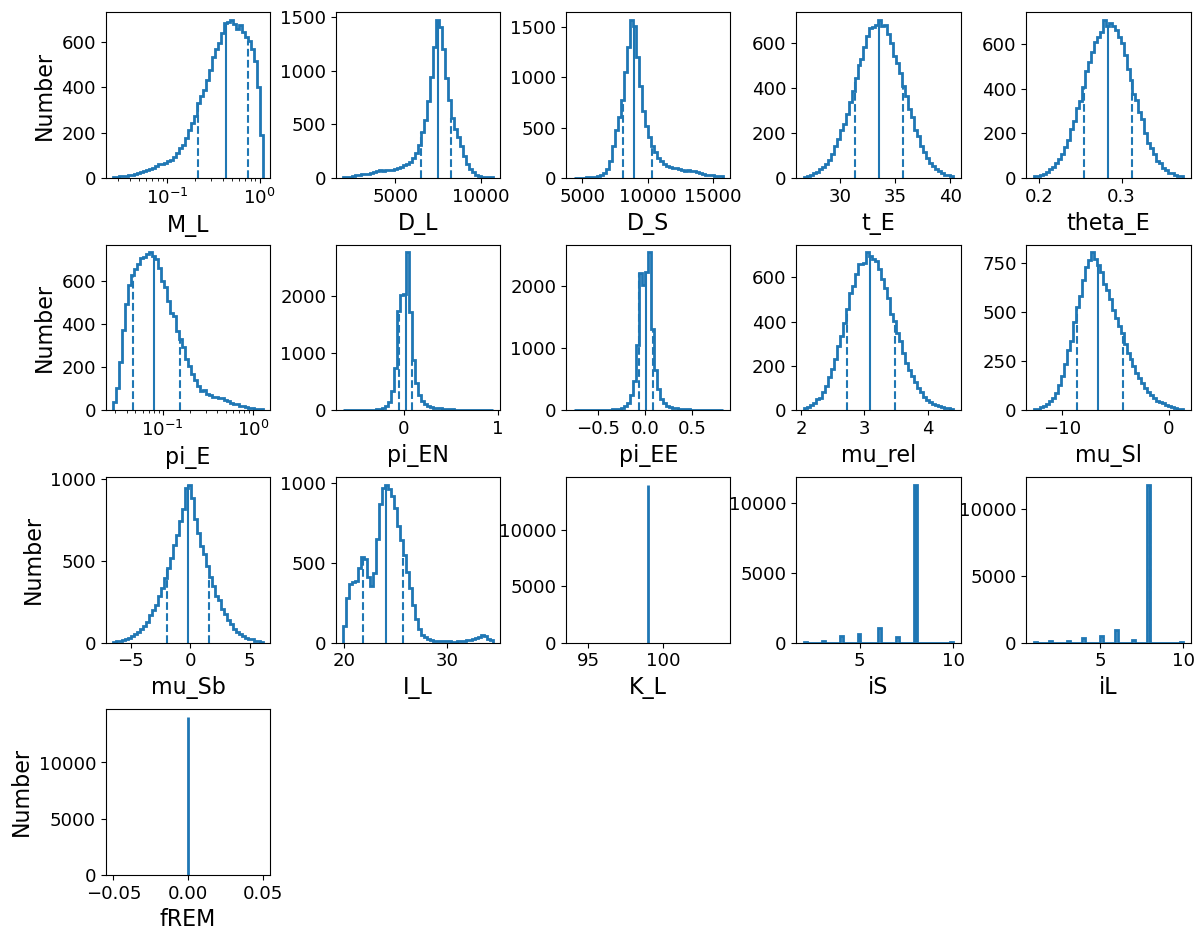

In [8]:
wtcol = 0  # column of wtj, weight for each line
data = print_data(file1, header, DISP = True)
ptiles = hist_wt(data, header, logparams = ['M_L', 'pi_E'], wtcol = wtcol, PLOT = True) # logparams: header name you want to plot in logscale

and the percentiles of each parameter are

In [9]:
print ("Percentiles weighted by ", header[wtcol] , " : ")
print ("#             -2sigma      -1sigma       median      +1sigma      +2sigma")
for i, ptile in enumerate(ptiles):
    if ptile[4] == ptile[0] : continue
    print('{:8s} {:12.5e} {:12.5e} {:12.5e} {:12.5e} {:12.5e}'.format(header[i], ptile[0], ptile[1], ptile[2], ptile[3], ptile[4]))

Percentiles weighted by  wtj  : 
#             -2sigma      -1sigma       median      +1sigma      +2sigma
M_L       7.59900e-02  2.17979e-01  4.39211e-01  7.49886e-01  9.76706e-01
D_L       3.84076e+03  6.52700e+03  7.50200e+03  8.27000e+03  9.20100e+03
D_S       7.15200e+03  8.12000e+03  8.98500e+03  1.03290e+04  1.37677e+04
t_E       2.91181e+01  3.13284e+01  3.35351e+01  3.57365e+01  3.79195e+01
theta_E   2.25406e-01  2.54669e-01  2.83656e-01  3.12878e-01  3.41953e-01
pi_E      3.50518e-02  4.70601e-02  7.92790e-02  1.55907e-01  4.58480e-01
pi_EN    -1.46156e-01 -5.27263e-02  2.28329e-02  9.16474e-02  2.90259e-01
pi_EE    -1.69778e-01 -6.01167e-02  1.16860e-02  7.88145e-02  2.30927e-01
mu_rel    2.38776e+00  2.72861e+00  3.09196e+00  3.48022e+00  3.89696e+00
mu_Sl    -1.03412e+01 -8.55160e+00 -6.66823e+00 -4.26826e+00 -1.53513e+00
mu_Sb    -4.01832e+00 -1.91381e+00 -1.55085e-01  1.59817e+00  3.67648e+00
I_L       2.04770e+01  2.18330e+01  2.41120e+01  2.57776e+01  2.93759e+01
iS   

So, the median and 1 sigma values of the posterior distributions of M_L and D_L are $M_L = 0.44^{+0.31}_{-0.22} M_{\odot}$ and $D_L = 7.5^{+0.8}_{-1.0}$ kpc.  Note that the pi_EN and pi_EE distributions are not correctly calculated because we haven't inputted the projected Earth velocity this time.

In the above, each line needs to be weighted by wtj, but the statistics for the unweighted case were also displayed using pandas.DataFrame.describe for comparison.

## Sample 2. Prior probability of microlens parallax

Currently, the measurement of microlens parallax is susceptible to systematic errors in the light curve, and modeling often results in an unlikely large value (e.g., $\pi_{\rm E} > 1$) and/or a direction of microlens parallax vector rarely expected considering the Galactic rotation.  
Even when a systematic error is not a problem, it is often the case only one-dimensional microlens parallax is measured.  
In both cases, a prior probability distribution of $(\pi_{\rm E,N}, \pi_{\rm E,E})$ based on a Galactic model helps your modeling.  
Let's see how this can be calculated with `genulens`, using the actual calculations I did in the analysis of OGLE-2018-BLG-1185 as an example.

In the OGLE-2018-BLG-1185 analysis ([Kondo et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....162...77K/abstract)), we have 1-D parallax measurement by the Spitzer telescope.  
We had tentatively measured $t_{\rm E} = 16.0 \pm 0.14$ days and $\theta_{\rm E} = 0.207 \pm 0.015$ mas without using the Spitzer data.  
So, a prior probability can be calculated just by `genulens tE 16.0 0.14 thetaE 0.207 0.015 [other options]`.  
However, considering possible correlations between the $(\pi_{\rm E,N}, \pi_{\rm E,E})$ and other parameters (i.e., $t_E$ and $\theta_E$), we wanted to avoid applying the normal probability likelihood which is assumed by running the above command.  
So, we decided to use the `UNIFORM 1` option to apply an uniform probability likelihood with larger uncertainties, which would allow us to multiply it by the probability distribution coming from the MCMC stationary distribution later.  (see Section 1.2 of [Usage.pdf](https://github.com/nkoshimoto/genulens/blob/main/Usage.pdf) for detail about this idea )

In [10]:
argtxt2 = ''
argtxt2 += ' l 2.47 b -2.00' # coordinate
argtxt2 += ' vEarthlb -24.3835 13.0860' # Earth projected velocity (l, b) in km/sec at t0. Needed to calculate (pi_E,N, pi_E,E)

# tE and thetaE constraints with significantly increased errors so that it covers major parameter space explored by MCMC. 
tEval, tEerr = 16.0, 0.5
thetaEval, thetaEerr = 0.207, 0.050
argtxt2 += ' tE {:.2f} {:.2f}'.format(tEval,tEerr)     #  tE constraint. 
argtxt2 += ' thetaE {:.3f} {:.3f}'.format(thetaEval, thetaEerr)  #  thetaE constraint.
argtxt2 += ' UNIFORM 1'  # use uniform probability as likelihood (eq. 2 in Section 1.1 of Usage.pdf)

# For D_S distribution (see Section 3-I-3.1 in Usage.pdf)
argtxt2 += ' Isrange 19.8 20.4 AIrc 1.96' #  Needed to calculate I_{S,0} as a function of D_S
argtxt2 += ' VIsrange 2.24 2.44 EVIrc 1.66' #  Needed to calculate (V-I)_{S,0} as a function of D_S
argtxt2 += ' DMrc 14.47' # mean RC distance modulus taken from the OGLE extinction calculator (Nataf+13)

# To output events with small probability 
argtxt2 += ' SMALLGAMMA 1' # see Section 3-II-2 in Usage.pdf

# output parameters
argtxt2 += ' VERBOSITY 3'  # 2 or 3.  I used 2 in the actual calculation to reduce the output size, but I use 3 for here

print("Sample 2 argument for genulens : ")
print(argtxt2)

file2 = 'sample2.dat'

Sample 2 argument for genulens : 
 l 2.47 b -2.00 vEarthlb -24.3835 13.0860 tE 16.00 0.50 thetaE 0.207 0.050 UNIFORM 1 Isrange 19.8 20.4 AIrc 1.96 VIsrange 2.24 2.44 EVIrc 1.66 DMrc 14.47 SMALLGAMMA 1 VERBOSITY 3


Difference from Sample 1 is :
- `vEarthlb -24.3835 13.0860` :   
Earth projected velocity (l, b) in km/sec at t0. Needed to calculate $(\pi_{\rm E,N}, \pi_{\rm E,E})$ correctly.


- `tE 16.00 0.50 thetaE 0.207 0.050 UNIFORM 1` :   
The `UNIFORM 1` option uses the uniform probability 
$$
{\cal L}_{p} = 
\begin{cases}
1 & \text{ when $|\texttt{val} - p| \leq \texttt{err}$} \\
0 & \text{  when $|\texttt{val} - p| > \texttt{err}$ } 
\end{cases}
$$  
as likelihood instead of $\exp[-0.5(p - \texttt{val})^2/\texttt{err}^2]$ when `p [val] [err]` is given. (p = tE, thetaE, here).  
Accordingly, the errors for tE and thetaE are taken significantly larger than $1 \sigma$ so that it covers major parameter space explored by MCMC.  
Again see Section 1.2 of [Usage.pdf](https://github.com/nkoshimoto/genulens/blob/main/Usage.pdf) for the detail of the idea behind this.


- `Isrange 19.8 20.4 AIrc 1.96 VIsrange 2.24 2.44 EVIrc 1.66 DMrc 14.47` :   
These are needed to calculate the $D_S$ distribution with the source mag constraints.  Narrowing the allowed value of $D_S$ can also narrow the allowed range of parallax vector. How the $D_S$ distribution is calculated is presented in Section 3-I-3.1 of [Usage.pdf](https://github.com/nkoshimoto/genulens/blob/main/Usage.pdf). Note that adding these does not slow down the calculation since the calculation of the $D_S$ distribution is done before the Monte Carlo simulation part.


- `SMALLGAMMA 1` :   
Outputs all generated events although `genulens`  normally does not output events with extremely small event rate ($\propto D_L^2 \theta_{\rm E} \mu_{\rm rel}$) to reduce the amount of output.  See Section 3-II-2 of [Usage.pdf](https://github.com/nkoshimoto/genulens/blob/main/Usage.pdf) for detail of this option.  
This time I use this option to quantitatively calculate the probability distribution of $(\pi_{\rm E,N}, \pi_{\rm E,E})$ over a wide area of the parameter space, including very low probability parts. 


### 2.1 Test run

So, let's do a test run. (with a larger number because acceptance ratio with `SMALLGAMMA 1` is larger than without it.)

In [11]:
%%time
# Test run 
NlikeMIN = ' NlikeMIN 1e+5'
header = run_genulens(file2, argtxt2 + NlikeMIN)

# Conducted command (you can do this directly in your command line too): 

 ./genulens  l 2.47 b -2.00 vEarthlb -24.3835 13.0860 tE 16.00 0.50 thetaE 0.207 0.050 UNIFORM 1 Isrange 19.8 20.4 AIrc 1.96 VIsrange 2.24 2.44 EVIrc 1.66 DMrc 14.47 SMALLGAMMA 1 VERBOSITY 3 NlikeMIN 1e+5 > sample2.dat 

CPU times: user 965 μs, sys: 5.57 ms, total: 6.54 ms
Wall time: 661 ms


In [12]:
show_header(file2, 30, 48)


 sed -n 30,48p sample2.dat 

#     X5: M= 3.31e+09 Msun, rho0X=  5.93 Msun/pc^3, (x0, y0, z0, Rc)= ( 278,  176, 287, 1302) pc, (C1, C2, b_zX)= (1.3, 2.2, 1.4)
#   (Omega_p, vx_str)= ( 47.4 km/s/kpc,  43[1 - e^{-(|yb|/ 407)^2}] km/s ), sig0+1(xb, yb, zb)= (152+ 64,  78+ 76,  82+ 71) km/s
#   sigR5: (x0, y0, z0)= (  858,  3217,   951) pc, (C1, C2, C3)= (4.3, 1.0, 1.0)
#   sigZ5: (x0, y0, z0)= (  558,  2003,  3823) pc, (C1, C2, C3)= (3.7, 1.1, 1.0)
#   ND= 0     (0: no NSD, 1: Portail+17's NSD, 2: Sormani+22-like NSD, 3: Use Sormani+22's DF's moments)
#   SH= 1     (0: no stellar halo, 1: Robin+03's Spheroid)
#-------------- Input parameters ---------------
#    CenSgrA= 1     (0: GC at (l,b)=(0,0), 1: GC at (l,b)= (-0.056, -0.046))
#    UNIFORM= 1     (0: L= N(obs, err), 1: L= U(obs-err, obs+err))
#    REMNANT= 0     (0: no remnant, 1: with remnant)
#     onlyWD= 0     (1: w/ remnant but only WD)
#     BINARY= 0     (0: no binary , 1: with binary )
# SMALLGAMMA= 1     (1: output all eve

### 2.2 Parallel run (not executed here)

Now that we aim to have a moderate resolution in the 2D probability distribution of $(\pi_{\rm E,N}, \pi_{\rm E,E})$ including low probability areas of the parameter space, we need much larger simulation than the previous case.  
There was no clear rationale, but we decided to output 50 million events. I could have done the calculation on my laptop if I had taken the time, but fortunately, I was allowed to use a server at Osaka University, so I did the calculations in parallel.  
In this notebook, parallel computation is not performed, but there is a caveat that the random seed value must be changed in the argument for parallel computation, so I only show an example of the execution commands below, and then actually run just one of them.  

Although now the above test only took ~2 secs thanks to the importance sampling feature introduced in version 1.2, the same command had taken ~30 secs until version 1.1 of `genulens`.
So when I analyzed this event, I decided to divide the 50 million calculations into 50 parallel runs with `NlikeMIN 1e+6` ;

In [13]:
# Just to show the commands for the parallel run.
Nrun = 50
NlikeMIN = ' NlikeMIN 1e+6'
commands = [argtxt2 + NlikeMIN + ' seed {}'.format(i+1) for i in range(Nrun)]
print("# Example commands for a parallel run : \n")
for command in commands :
    print('./genulens', command)

# Example commands for a parallel run : 

./genulens  l 2.47 b -2.00 vEarthlb -24.3835 13.0860 tE 16.00 0.50 thetaE 0.207 0.050 UNIFORM 1 Isrange 19.8 20.4 AIrc 1.96 VIsrange 2.24 2.44 EVIrc 1.66 DMrc 14.47 SMALLGAMMA 1 VERBOSITY 3 NlikeMIN 1e+6 seed 1
./genulens  l 2.47 b -2.00 vEarthlb -24.3835 13.0860 tE 16.00 0.50 thetaE 0.207 0.050 UNIFORM 1 Isrange 19.8 20.4 AIrc 1.96 VIsrange 2.24 2.44 EVIrc 1.66 DMrc 14.47 SMALLGAMMA 1 VERBOSITY 3 NlikeMIN 1e+6 seed 2
./genulens  l 2.47 b -2.00 vEarthlb -24.3835 13.0860 tE 16.00 0.50 thetaE 0.207 0.050 UNIFORM 1 Isrange 19.8 20.4 AIrc 1.96 VIsrange 2.24 2.44 EVIrc 1.66 DMrc 14.47 SMALLGAMMA 1 VERBOSITY 3 NlikeMIN 1e+6 seed 3
./genulens  l 2.47 b -2.00 vEarthlb -24.3835 13.0860 tE 16.00 0.50 thetaE 0.207 0.050 UNIFORM 1 Isrange 19.8 20.4 AIrc 1.96 VIsrange 2.24 2.44 EVIrc 1.66 DMrc 14.47 SMALLGAMMA 1 VERBOSITY 3 NlikeMIN 1e+6 seed 4
./genulens  l 2.47 b -2.00 vEarthlb -24.3835 13.0860 tE 16.00 0.50 thetaE 0.207 0.050 UNIFORM 1 Isrange 19.8 20.4 

Note that the seed value must be a positive integer. 

### 2.3 Run one of the commands in the parallel computation
Here, just run one of them.  
(Note that the following command will create a 160 MB file in your directory, so be careful if your storage space is limited. You can delete the file later of course.)

In [14]:
%%time
# Run one command
header = run_genulens(file2, commands[0])

# Conducted command (you can do this directly in your command line too): 

 ./genulens  l 2.47 b -2.00 vEarthlb -24.3835 13.0860 tE 16.00 0.50 thetaE 0.207 0.050 UNIFORM 1 Isrange 19.8 20.4 AIrc 1.96 VIsrange 2.24 2.44 EVIrc 1.66 DMrc 14.47 SMALLGAMMA 1 VERBOSITY 3 NlikeMIN 1e+6 seed 1 > sample2.dat 

CPU times: user 1.23 ms, sys: 5.47 ms, total: 6.7 ms
Wall time: 4.48 s


,wtj,M_L,D_L,D_S,t_E,theta_E,pi_E,pi_EN,pi_EE,mu_rel,mu_Sl,mu_Sb,I_L,K_L,iS,iL,fREM
0,0.016755,0.421767,7448.0,8162.0,16.05316,0.200895,0.058488,0.005530,0.058226,4.570872,-7.69694,3.058470,24.525,99.0,8.0,8.0,0.0
1,0.000506,0.018524,2002.0,7937.0,16.43063,0.237348,1.573342,0.714518,1.401738,5.276201,-4.33156,0.653427,35.403,99.0,6.0,2.0,0.0
2,0.002415,0.337529,6190.0,7264.0,15.68483,0.256214,0.093209,0.084760,-0.038778,5.966416,-1.93077,-0.588496,24.587,99.0,8.0,7.0,0.0
3,0.007645,0.351723,6852.0,7570.0,15.71125,0.199035,0.069486,-0.056596,0.040314,4.627091,-3.89389,1.435770,24.782,99.0,8.0,8.0,0.0
4,0.016320,0.292050,7067.0,8769.0,15.74324,0.255549,0.107444,-0.010987,0.106881,5.928841,-7.55978,4.510400,25.360,99.0,8.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000294,0.003859,0.403683,6945.0,7395.0,16.33358,0.169743,0.051632,-0.032770,-0.039900,3.795784,-2.64599,-1.418700,24.443,99.0,8.0,8.0,0.0
1000295,0.037854,0.347650,7797.0,9329.0,15.76789,0.244178,0.086245,-0.001356,0.086234,5.656190,-6.96991,3.566860,25.197,99.0,8.0,8.0,0.0
1000296,0.003850,0.067722,3972.0,7516.0,16.34471,0.255885,0.463961,0.315290,0.340371,5.718174,-9.13949,1.817560,32.339,99.0,8.0,5.0,0.0
1000297,0.032831,0.422598,8246.0,9683.0,15.67159,0.248920,0.072327,0.012730,0.071198,5.801455,-8.49487,1.054940,24.818,99.0,4.0,8.0,0.0


Unweighted statistics (just for reference) : 


,wtj,M_L,D_L,D_S,t_E,theta_E,pi_E,pi_EN,pi_EE,mu_rel,mu_Sl,mu_Sb,I_L,K_L,iS,iL,fREM
count,1.000299e+06,1.000299e+06,1.000299e+06,1.000299e+06,1.000299e+06,1.000299e+06,1.000299e+06,1.000299e+06,1.000299e+06,1.000299e+06,1.000299e+06,1.000299e+06,1.000299e+06,1000299.0,1.000299e+06,1.000299e+06,1000299.0
mean,9.858737e-03,3.216269e-01,5.994372e+03,7.762657e+03,1.598554e+01,2.047905e-01,3.682626e-01,1.149446e-01,1.388206e-01,4.681852e+00,-5.571265e+00,-2.346093e-01,2.730353e+01,99.0,7.495926e+00,6.672000e+00,0.0
std,8.899699e-03,2.872128e-01,1.900673e+03,1.094575e+03,2.926260e-01,2.987280e-02,7.688629e-01,5.686579e-01,6.090258e-01,6.957789e-01,2.845089e+00,2.439663e+00,4.989328e+00,0.0,1.327704e+00,1.949677e+00,0.0
min,1.052271e-08,1.000577e-03,1.330000e+02,1.049000e+03,1.550000e+01,1.570000e-01,7.977078e-03,-2.466768e+01,-2.529446e+01,3.475560e+00,-2.214860e+01,-1.228240e+01,1.624900e+01,99.0,0.000000e+00,0.000000e+00,0.0
25%,2.317286e-03,7.472147e-02,4.772000e+03,7.341000e+03,1.572720e+01,1.786676e-01,5.104638e-02,-2.330249e-02,-2.607495e-02,4.082557e+00,-7.596025e+00,-1.865830e+00,2.398000e+01,99.0,8.000000e+00,6.000000e+00,0.0
50%,7.576861e-03,2.414899e-01,6.785000e+03,7.787000e+03,1.597860e+01,2.033519e-01,1.016910e-01,3.218360e-02,2.630465e-02,4.645917e+00,-5.632330e+00,-2.055830e-01,2.573700e+01,99.0,8.000000e+00,8.000000e+00,0.0
75%,1.538852e-02,4.943055e-01,7.407000e+03,8.262000e+03,1.624008e+01,2.303401e-01,3.342415e-01,1.363237e-01,1.168858e-01,5.263077e+00,-3.616465e+00,1.402960e+00,3.056500e+01,99.0,8.000000e+00,8.000000e+00,0.0
max,6.585492e-02,2.739517e+00,1.164700e+04,1.599300e+04,1.650000e+01,2.569997e-01,2.888029e+01,2.291618e+01,2.514047e+01,6.055691e+00,1.089560e+01,1.218820e+01,3.993400e+01,99.0,1.000000e+01,1.000000e+01,0.0


Histogram weighted by  wtj  : 


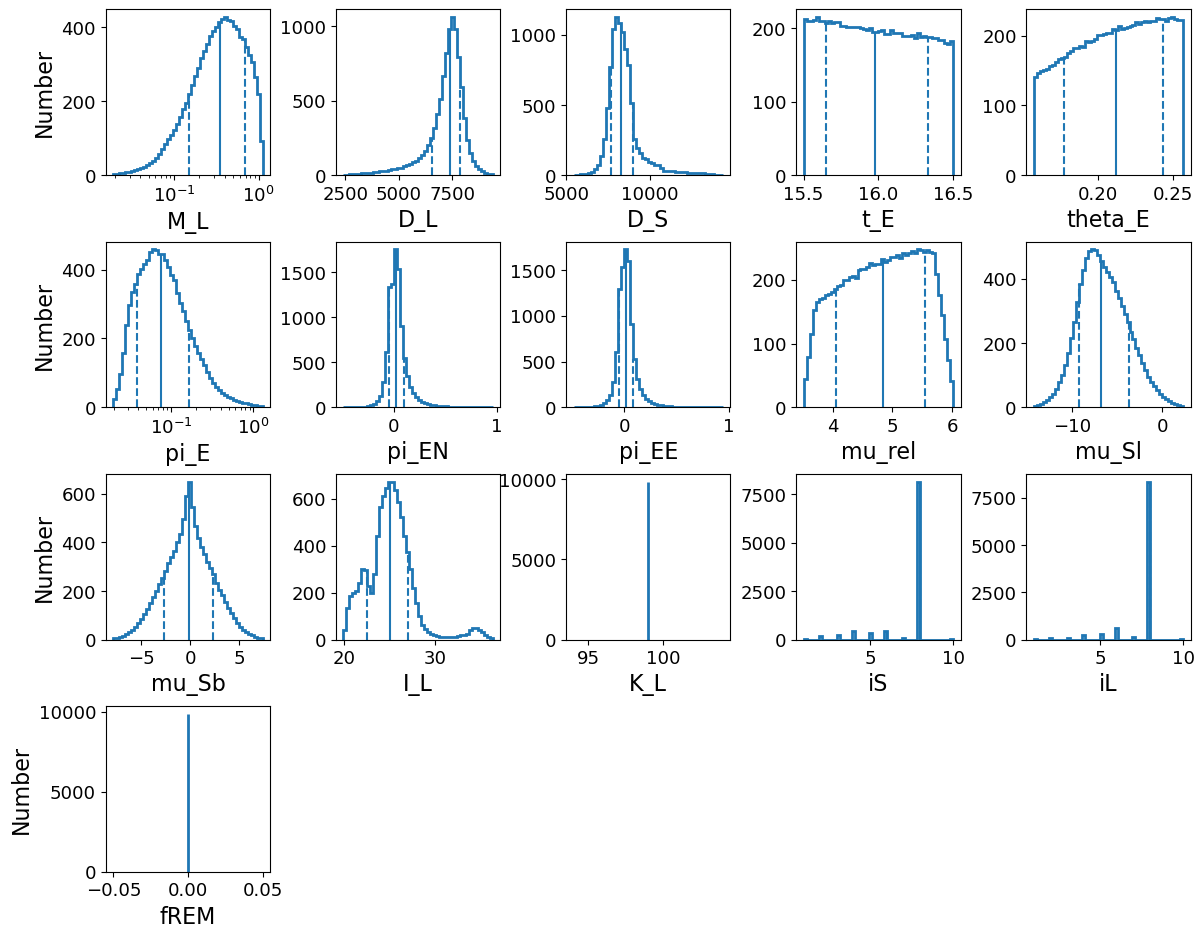

In [15]:
wtcol = 0  # column of wtj, weight for each line
data = print_data(file2, header, DISP = True)
ptiles = hist_wt(data, header, logparams = ['M_L', 'pi_E'], wtcol = wtcol, PLOT = True) # logparams: header name you want to plot in logscale

In [16]:
print ("Percentiles weighted by ", header[wtcol] , " : ")
print ("#             -2sigma      -1sigma       median      +1sigma      +2sigma")
for i, ptile in enumerate(ptiles):
    if ptile[4] == ptile[0] : continue
    print('{:8s} {:12.5e} {:12.5e} {:12.5e} {:12.5e} {:12.5e}'.format(header[i], ptile[0], ptile[1], ptile[2], ptile[3], ptile[4]))

Percentiles weighted by  wtj  : 
#             -2sigma      -1sigma       median      +1sigma      +2sigma
M_L       5.95704e-02  1.51036e-01  3.47492e-01  6.85368e-01  9.81951e-01
D_L       4.48900e+03  6.54300e+03  7.37700e+03  7.87100e+03  8.47200e+03
D_S       7.11600e+03  7.71700e+03  8.28600e+03  9.02200e+03  1.14970e+04
t_E       1.55212e+01  1.56484e+01  1.59800e+01  1.63301e+01  1.64754e+01
theta_E   1.60149e-01  1.77138e-01  2.12171e-01  2.43032e-01  2.54987e-01
pi_E      2.59938e-02  3.85075e-02  7.41694e-02  1.64923e-01  4.28654e-01
pi_EN    -1.27653e-01 -4.23006e-02  2.41205e-02  1.01794e-01  3.04059e-01
pi_EE    -1.38597e-01 -4.64589e-02  1.70763e-02  8.67928e-02  2.66033e-01
mu_rel    3.65451e+00  4.04705e+00  4.84678e+00  5.55212e+00  5.86992e+00
mu_Sl    -1.14825e+01 -9.19629e+00 -6.77408e+00 -3.71278e+00 -6.99626e-01
mu_Sb    -5.24786e+00 -2.66932e+00 -1.57352e-01  2.29317e+00  4.82746e+00
I_L       2.06840e+01  2.25130e+01  2.50230e+01  2.69650e+01  3.39570e+01
iS   

The $(\pi_{\rm E,N}, \pi_{\rm E,E})$ distribution looks like 

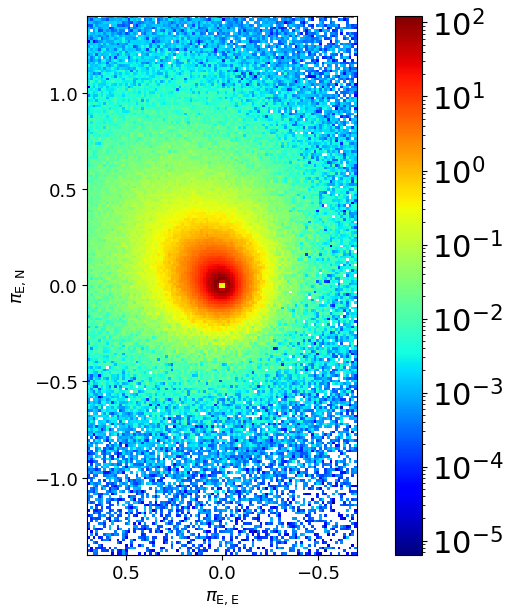

In [17]:
# Plot P(pi_EN, pi_EE)
dataT = data.T
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.rcParams["font.size"] = 22
# ax = fig.add_subplot(111)
NXBIN, NYBIN = 100, 200
xmin, xmax = -0.7, 0.7
ymin, ymax = -1.4, 1.4
# ZMIN, ZMAX
xedges =     np.linspace(xmin, xmax, NXBIN+1)
yedges =     np.linspace(ymin, ymax, NYBIN+1)
H2D, xedges, yedges = np.histogram2d(dataT[8], dataT[7], weights= dataT[0], bins=(xedges, yedges))
import matplotlib as mpl
plt.pcolormesh(xedges, yedges, H2D.T, cmap='jet', norm=mpl.colors.LogNorm())
cbar= plt.colorbar()
ax.set_xlabel(r'$\pi_{\rm E, E}$')
ax.set_ylabel(r'$\pi_{\rm E, N}$')
ax.set_aspect("equal", "box")
ax.invert_xaxis()

See Fig. 5 of [Kondo et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021AJ....162...77K/abstract) for a higher resolution version of the distribution using all 50 million events.

## Sample 3. Planetary event analysis with a white dwarf host possibility
The above analysis assumed that the lens objects were ordinary stars, but the discovery of a planet around a white dwarf by [Blackman et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021Natur.598..272B/abstract) implies that white dwarfs also have planets with non-negligible frequency in the microlensing sensitive region.  
You can add the white dwarf lens possibility using the `onlyWD 1` option. Let's repeat the sample 1 analysis with that option. 

In [18]:
argtxt3 = argtxt1 + ' onlyWD 1'
file3 = 'sample3.dat'

In [19]:
%%time
# run to have the posterior distribution of ML and DL
NlikeMIN = ' NlikeMIN 1e+5'
header = run_genulens(file3, argtxt3 + NlikeMIN) 

# Conducted command (you can do this directly in your command line too): 

 ./genulens  l -0.08 b -3.45 tE 34.0 2.2 thetaE 0.28 0.03 IL 20.67 0.47 ILdet 2 AIrc 1.63 VERBOSITY 3 onlyWD 1 NlikeMIN 1e+5 > sample3.dat 

CPU times: user 1.55 ms, sys: 11.5 ms, total: 13.1 ms
Wall time: 5.98 s


,wtj,M_L,D_L,D_S,t_E,theta_E,pi_E,pi_EN,pi_EE,mu_rel,mu_Sl,mu_Sb,I_L,K_L,iS,iL,fREM
0,0.300012,0.464647,7674.0,8806.0,33.64228,0.251803,0.066544,-0.059943,-0.028895,2.733798,-4.02759,0.502332,24.001,99.0,8.0,8.0,0.0
1,0.306731,0.431966,7946.0,9519.0,28.70307,0.270485,0.076888,0.026197,0.072288,3.441948,-9.22373,2.898030,24.299,99.0,8.0,8.0,0.0
2,0.155479,0.317595,6878.0,8390.0,33.75954,0.260280,0.100632,0.097005,0.026773,2.816014,-5.63990,-0.509206,24.784,99.0,8.0,2.0,0.0
3,0.423080,0.527928,7782.0,10071.0,33.52770,0.354429,0.082437,0.045211,-0.068934,3.861141,-7.46509,-3.016870,23.655,99.0,8.0,8.0,0.0
4,0.177063,0.326162,7108.0,8662.0,34.47610,0.258861,0.097454,-0.089660,-0.038189,2.742447,-4.74980,1.451550,24.796,99.0,8.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101951,0.308116,0.422702,7291.0,8785.0,37.20075,0.283406,0.082327,0.053907,0.062223,2.782578,-7.49578,0.071292,24.149,99.0,8.0,8.0,0.0
101952,0.181740,0.567344,6939.0,7987.0,35.95421,0.295508,0.063957,0.063815,-0.004260,3.001996,-7.46693,0.864707,23.133,99.0,8.0,8.0,0.0
101953,0.055020,0.297894,5680.0,7056.0,33.02126,0.288628,0.118972,0.027462,0.115759,3.192533,-6.05394,-3.020950,24.455,99.0,8.0,8.0,0.0
101954,0.291281,0.478175,7365.0,9069.0,31.69361,0.315161,0.080931,0.078807,-0.018418,3.632048,-6.98112,0.702126,23.814,99.0,8.0,8.0,0.0


Unweighted statistics (just for reference) : 


,wtj,M_L,D_L,D_S,t_E,theta_E,pi_E,pi_EN,pi_EE,mu_rel,mu_Sl,mu_Sb,I_L,K_L,iS,iL,fREM
count,101956.000000,101956.000000,101956.000000,101956.000000,101956.000000,101956.000000,101956.000000,101956.000000,101956.000000,101956.000000,101956.000000,101956.000000,101956.000000,101956.0,101956.000000,101956.000000,101956.000000
mean,0.199708,0.497973,6940.203058,8684.448595,33.423663,0.283882,0.131745,0.029371,0.011430,3.116752,-5.964791,-0.171955,40.978819,99.0,7.557191,7.339705,0.222253
std,0.096381,0.273407,1461.197865,1510.004776,2.253266,0.029375,0.205112,0.175523,0.166211,0.388941,2.425114,1.971665,31.120757,0.0,1.136470,1.405920,0.415762
min,0.000288,0.003224,452.000000,824.000000,24.743200,0.162794,0.018628,-6.032311,-6.348801,1.659394,-14.712500,-10.453500,19.072000,99.0,0.000000,0.000000,0.000000
25%,0.124113,0.267874,6525.750000,7869.000000,31.904953,0.264100,0.051007,-0.032817,-0.038575,2.850501,-7.690745,-1.413218,23.166000,99.0,8.000000,8.000000,0.000000
50%,0.205051,0.518769,7320.000000,8599.000000,33.428710,0.283977,0.069016,0.019965,0.010672,3.102044,-6.167820,-0.163855,24.980000,99.0,8.000000,8.000000,0.000000
75%,0.262659,0.683535,7806.000000,9234.000000,34.939733,0.303506,0.127738,0.059624,0.051982,3.366629,-4.402175,1.072923,33.010250,99.0,8.000000,8.000000,0.000000
max,0.770230,1.374851,12600.000000,15999.000000,42.768690,0.398135,8.757629,3.888784,5.441548,5.028088,5.446250,8.801270,99.000000,99.0,10.000000,10.000000,1.000000


Histogram weighted by  wtj  : 


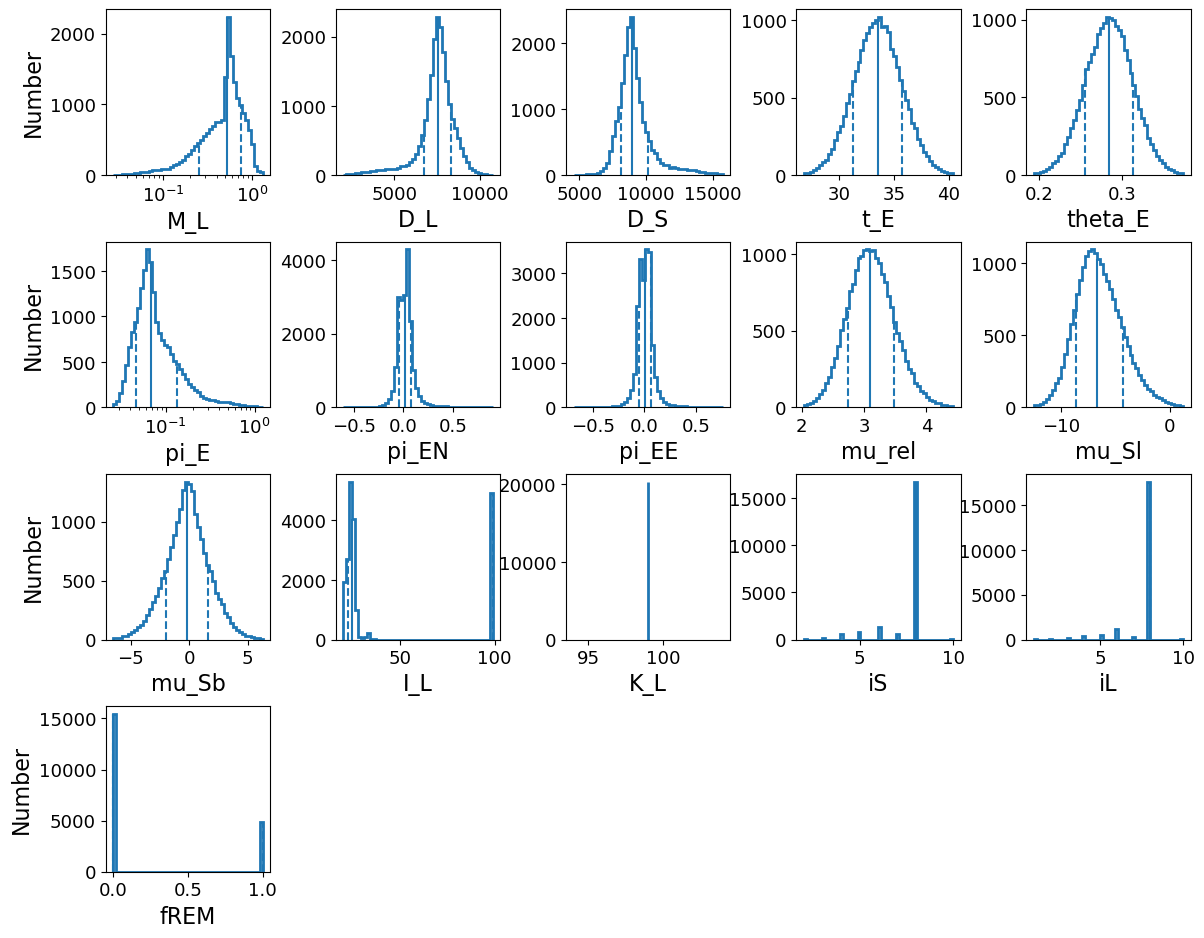

In [20]:
wtcol = 0  # column of wtj, weight for each line
data = print_data(file3, header, DISP = True)
ptiles = hist_wt(data, header, logparams = ['M_L', 'pi_E'], wtcol = wtcol, PLOT = True) # logparams: header name you want to plot in logscale

You can see that a sharp peak has appeared at ~0.5 Msun in the M_L distribution, corresponding to the white dwarf population.    
Also, the fREM now takes not only 0, but also 1, which indicates a white dwarf lens.  
Finally, note that using the `onlyWD 1` option for a planetary event analysis implicitly assumes that the planet-hosting probability is the same for a white dwarf as for a normal star.

## Sample 4. Black hole candidate analysis
You can consider a neutron star or black hole lens possibility by using the `REMNANT 1` option.  
Let's apply that option to a Bayesian analysis for a black-hole candidate OGLE3-ULENS-PAR-02 ([Wyrzykowski et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.458.3012W/abstract)).
 

In [21]:
# u0-, piEN- solution
argtxt4 = ''
argtxt4 += ' l 1.45 b -2.13' # coordinate
argtxt4 += ' vEarthlb -13.24 19.67' # Earth projected velocity (l, b) in km/sec at t0. Needed to calculate (pi_E,N, pi_E,E)

# tE and piE constraints. 
tEpiEobs = ''
tEpiEobs += ' tE 288.8 8.0'     #  tE constraint. 
tEpiEobs += ' piEN -0.033 0.001 piEE -0.073 0.004'  #  parallax constraint.  

# For D_S distribution 
argtxt4 += ' Isrange 15.30 15.60 AIrc 1.42' #  taken conservatively large
argtxt4 += ' VIsrange 1.89 2.54 EVIrc 1.14' #  roughly read from the CMD 
argtxt4 += ' DMrc 14.494' # mean RC distance modulus taken from the OGLE extinction calculator (Nataf+13)

# IL constraint 
argtxt4 += ' IL 17.7 0.01 ILdet 2' # lower limit on IL

# To output events with small probability.
argtxt4 += ' SMALLGAMMA 1' # see Section 3-II-2 in Usage.pdf

# To consider the REMNANT possibility
argtxt4 += ' REMNANT 1'

# output parameters
argtxt4 += ' VERBOSITY 3'  # 2 or 3.  

print("Sample 4 argument for genulens : ")
print(argtxt4 + tEpiEobs)

file4 = 'sample4.dat'

Sample 4 argument for genulens : 
 l 1.45 b -2.13 vEarthlb -13.24 19.67 Isrange 15.30 15.60 AIrc 1.42 VIsrange 1.89 2.54 EVIrc 1.14 DMrc 14.494 IL 17.7 0.01 ILdet 2 SMALLGAMMA 1 REMNANT 1 VERBOSITY 3 tE 288.8 8.0 piEN -0.033 0.001 piEE -0.073 0.004


### 4.1 Test run (comparison between parallax vector and amplitude constraints)
This time the computation is expected to be very slow because of  
1. An uncommonly large tE value :  
In each trial of the Monte Carlo simulation, `genulens` calculates $M_{\rm cand} = (\mu_{\rm rel} t_{\rm E, cand})^2/(\kappa \pi_{\rm rel})$ from a randomly generated combination of ($D_L$, $D_S$, $\mu_{\rm rel}$) and the candidate $t_{\rm E}$ value determined from the input $t_E$ range. However, if the input $t_E$ value is large, this $M_{\rm cand} \propto t_{\rm E, cand}^2$ is quite likely to be larger than the maximum mass of the mass function, so many simulations are needed to have a reasonable mass distribution. 


2. ($\pi_{\rm E, N}, \pi_{\rm E, E}$) constraints with small error bars :  
Although `genulens` is good at simulation limited to the range of the input $\pi_E$, it is not able to limit simulation to a certain sky direction. So it is time-consuming if the parallax vector direction is specified, especially when the error bars are small.

These are two features that `genulens` is currently not very good at, and we want to avoid them if possible.  
Although the large tE value is inevitable, parallax vector constraints might be avoidable if there is no essential difference from the results with parallax amplitude constraint.  
Here, let's see if there is a significant difference between them with a small NlikeMIN value.  


### 4.1.1  With parallax vector (piEN, piEE) constraint


In [22]:
# tE and piE constraints. 
tEpiEobs = ''
tEpiEobs += ' tE 288.8 8.0'     #  tE constraint. 
tEpiEobs += ' piEN -0.033 0.001 piEE -0.073 0.004'  #  parallax constraint.  

In [23]:
%%time
# Test run for sample 4 with piEN, piEE
NlikeMIN = ' NlikeMIN 500'
header = run_genulens(file4, argtxt4 + tEpiEobs + NlikeMIN)

# Conducted command (you can do this directly in your command line too): 

 ./genulens  l 1.45 b -2.13 vEarthlb -13.24 19.67 Isrange 15.30 15.60 AIrc 1.42 VIsrange 1.89 2.54 EVIrc 1.14 DMrc 14.494 IL 17.7 0.01 ILdet 2 SMALLGAMMA 1 REMNANT 1 VERBOSITY 3 tE 288.8 8.0 piEN -0.033 0.001 piEE -0.073 0.004 NlikeMIN 500 > sample4.dat 

CPU times: user 3.38 ms, sys: 11.1 ms, total: 14.5 ms
Wall time: 5min 28s


With the real measured value, calculation took ~10 min only for a `NlikeMIN 500` calculation. The distribution with this looks like 

Results of test run with  tE 288.8 8.0 piEN -0.033 0.001 piEE -0.073 0.004
Histogram weighted by  wtj  : 


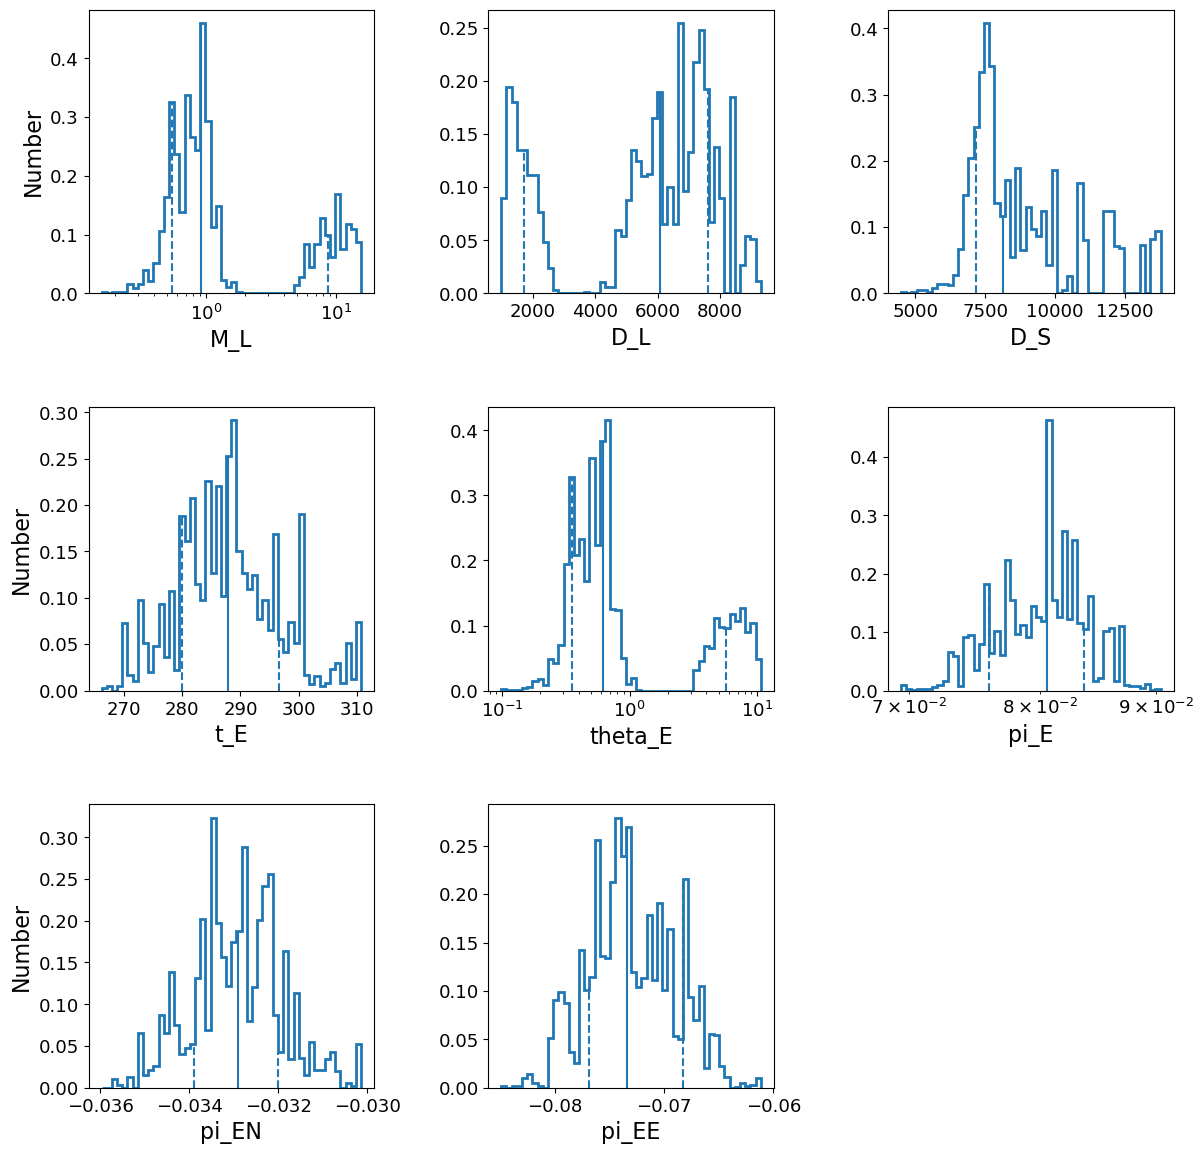

In [24]:
wtcol = 0  # column of wtj, weight for each line
data = print_data(file4, header, DISP = False)
print ('Results of test run with', tEpiEobs)
ptiles = hist_wt(data[:, 0:9], header, logparams = ['M_L', 'theta_E', 'pi_E', 'mu_rel', 'aL', 'aLpmin'], wtcol = wtcol, PLOT = True, NXBIN = 50) # logparams: header name you want to plot in logscale

### 4.1.2 With parallax amplitude (piE) constraint

In [25]:
# tE and piE constraints. 
tEpiEobs = ''
tEpiEobs += ' tE 288.8 8.0'     #  tE constraint. error bar doubled
tEpiEobs += ' piE {:.3f} 0.005'.format(np.sqrt(0.033**2 + 0.073**2))

In [26]:
%%time
# Test run for sample 4 with 1D piE
NlikeMIN = ' NlikeMIN 500'
header = run_genulens(file4, argtxt4 + tEpiEobs + NlikeMIN)

# Conducted command (you can do this directly in your command line too): 

 ./genulens  l 1.45 b -2.13 vEarthlb -13.24 19.67 Isrange 15.30 15.60 AIrc 1.42 VIsrange 1.89 2.54 EVIrc 1.14 DMrc 14.494 IL 17.7 0.01 ILdet 2 SMALLGAMMA 1 REMNANT 1 VERBOSITY 3 tE 288.8 8.0 piE 0.080 0.005 NlikeMIN 500 > sample4.dat 

CPU times: user 1.07 ms, sys: 11.8 ms, total: 12.9 ms
Wall time: 1.46 s


Results of test run with  tE 288.8 8.0 piE 0.080 0.005
Histogram weighted by  wtj  : 


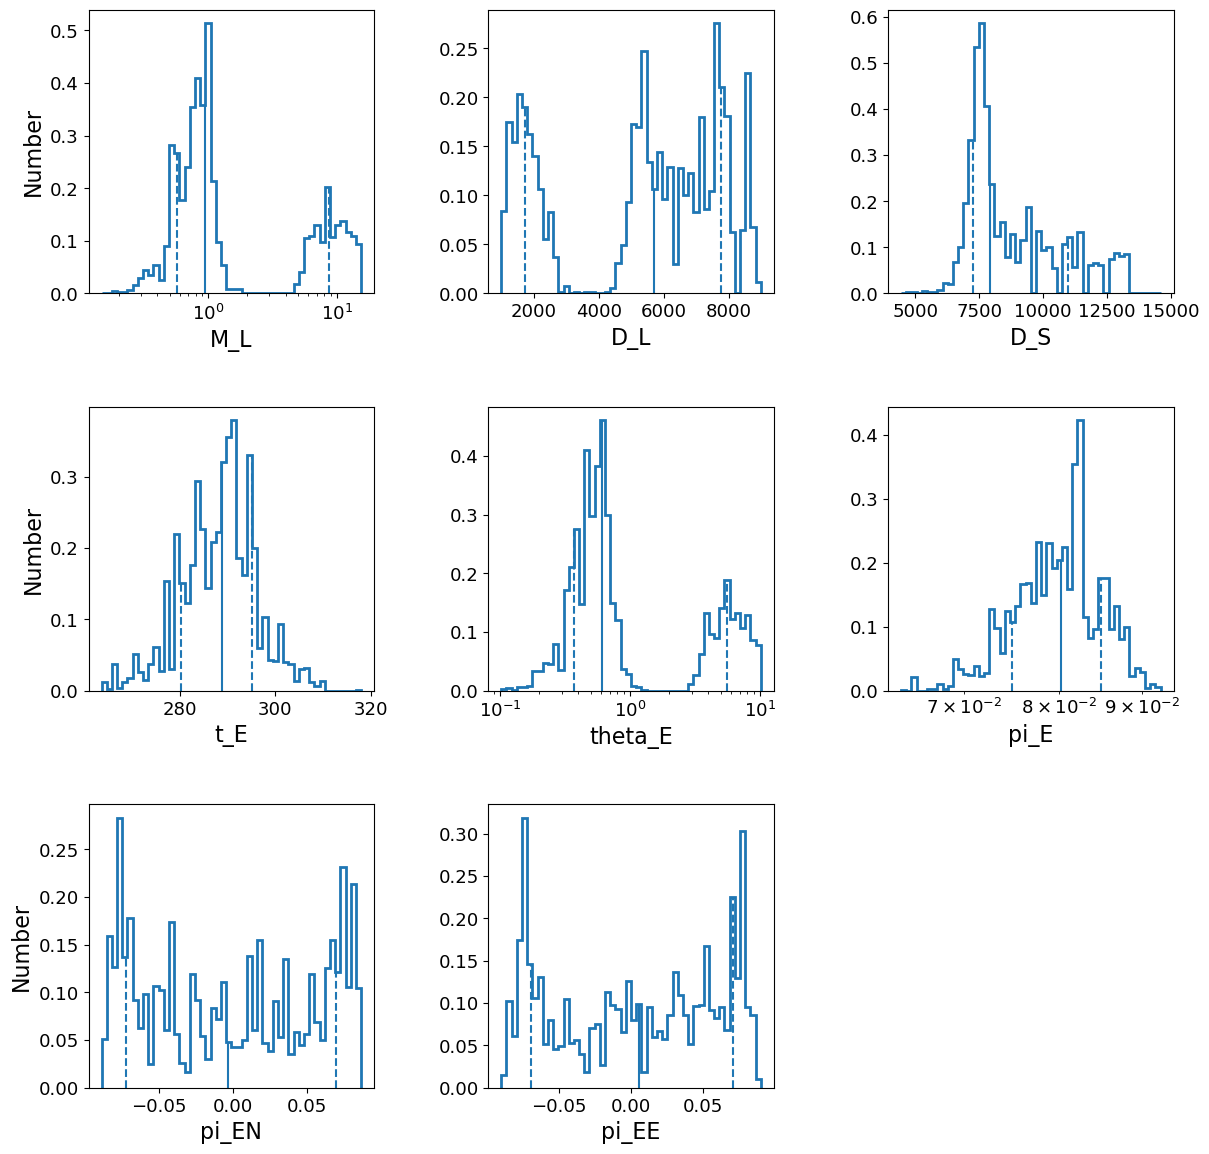

In [27]:
wtcol = 0  # column of wtj, weight for each line
data = print_data(file4, header, DISP = False)
print ('Results of test run with', tEpiEobs)
ptiles = hist_wt(data[:, 0:9], header, logparams = ['M_L', 'theta_E', 'pi_E', 'mu_rel', 'aL', 'aLpmin'], wtcol = wtcol, PLOT = True, NXBIN = 50) # logparams: header name you want to plot in logscale

So, the calculation with the parallax amplitude constraint is ~150 times faster than the calculation with the parallax vector constraint.  
These two results are similar, and both have bimodal M_L distributions: less massive lens with M_L < ~1.3 Msun and black hole lens with M_L > 5 Msun. Therefore, if this is a calculation for publication, I would calculate the 2-D parallax one using a parallel computation, but here we will calculate the 1-D parallax one, to save our time.

### 4.2 Run with desired `NlikeMIN`

Even with the parallax amplitude constraint, the calculation is much slower than other sample calculations. So, here I use NlikeMIN = 50000.

In [28]:
%%time
# run to have the posterior distribution of ML and DL
NlikeMIN = ' NlikeMIN 50000'
header = run_genulens(file4, argtxt4 + tEpiEobs + NlikeMIN)

# Conducted command (you can do this directly in your command line too): 

 ./genulens  l 1.45 b -2.13 vEarthlb -13.24 19.67 Isrange 15.30 15.60 AIrc 1.42 VIsrange 1.89 2.54 EVIrc 1.14 DMrc 14.494 IL 17.7 0.01 ILdet 2 SMALLGAMMA 1 REMNANT 1 VERBOSITY 3 tE 288.8 8.0 piE 0.080 0.005 NlikeMIN 50000 > sample4.dat 

CPU times: user 1.69 ms, sys: 10.5 ms, total: 12.2 ms
Wall time: 1min 23s


,wtj,M_L,D_L,D_S,t_E,theta_E,pi_E,pi_EN,pi_EE,mu_rel,mu_Sl,mu_Sb,I_L,K_L,iS,iL,fREM
0,0.000412,0.180270,6904.0,7411.0,281.2939,0.120622,0.082162,0.081648,-0.009174,0.156623,-4.538240,-1.444440,26.008,99.0,4.0,8.0,0.0
1,0.038634,0.519497,7197.0,9405.0,287.7393,0.371515,0.087814,-0.087287,-0.009603,0.471594,-6.784910,0.711775,23.288,99.0,8.0,8.0,0.0
2,0.001524,10.549270,1735.0,5893.0,281.9644,5.910091,0.068792,-0.066844,-0.016255,7.655791,-2.495360,0.516290,99.000,99.0,6.0,5.0,3.0
3,0.002321,13.080300,1335.0,6865.0,289.8565,8.017351,0.075263,-0.003680,0.075173,10.102710,-2.657920,-4.748880,99.000,99.0,8.0,0.0,3.0
4,0.051027,0.862606,6719.0,9805.0,282.2409,0.573704,0.081666,0.073604,0.035382,0.742434,-4.124730,-2.550780,20.487,99.0,8.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,0.007351,1.000315,5207.0,7130.0,288.6401,0.649454,0.079722,-0.069862,-0.038405,0.821830,-0.996695,-0.908575,18.996,99.0,8.0,2.0,0.0
49995,0.000743,0.573805,3613.0,4112.0,287.6268,0.395920,0.084725,0.072724,0.043468,0.502768,-4.106270,-2.359920,99.000,99.0,5.0,3.0,1.0
49996,0.002890,9.337728,1679.0,7374.0,299.4180,5.913914,0.077768,-0.057211,-0.052676,7.214185,-2.295810,1.956200,99.000,99.0,8.0,5.0,3.0
49997,0.011089,0.773393,5763.0,7504.0,289.9690,0.503470,0.079936,-0.050768,0.061744,0.634179,-0.948242,1.407940,20.670,99.0,8.0,6.0,0.0


Unweighted statistics (just for reference) : 


,wtj,M_L,D_L,D_S,t_E,theta_E,pi_E,pi_EN,pi_EE,mu_rel,mu_Sl,mu_Sb,I_L,K_L,iS,iL,fREM
count,49999.000000,49999.000000,49999.000000,49999.00000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.0,49999.000000,49999.000000,49999.000000
mean,0.006382,5.669060,3483.445049,7428.49273,288.016323,3.645712,0.079394,0.003719,0.003437,4.624246,-4.596241,-0.341917,76.931957,99.0,7.239245,5.082622,1.915178
std,0.010869,4.588738,2198.602823,1056.41046,8.049965,2.957669,0.005067,0.056386,0.055894,3.753849,2.792146,2.123786,34.845069,0.0,1.625899,2.168728,1.352545
min,0.000002,0.021416,277.000000,345.00000,254.272100,0.014389,0.057576,-0.097638,-0.099493,0.018354,-21.407500,-10.787600,17.670000,99.0,1.000000,0.000000,0.000000
25%,0.001941,0.850111,1643.000000,7022.00000,282.586700,0.551710,0.075974,-0.052186,-0.051538,0.699618,-6.541885,-1.546965,25.191500,99.0,8.000000,4.000000,0.000000
50%,0.003130,6.169160,2221.000000,7362.00000,288.031500,3.992727,0.079367,0.007476,0.006570,5.061197,-4.378800,-0.309556,99.000000,99.0,8.000000,6.000000,3.000000
75%,0.006097,9.038695,5528.000000,7664.00000,293.443700,5.882821,0.082786,0.059600,0.058513,7.463200,-2.507470,0.890161,99.000000,99.0,8.000000,6.000000,3.000000
max,0.106898,15.677030,12160.000000,15949.00000,322.634900,11.639200,0.099625,0.098330,0.097113,14.772370,7.380730,10.394900,99.000000,99.0,10.000000,10.000000,3.000000


Histogram weighted by  wtj  : 


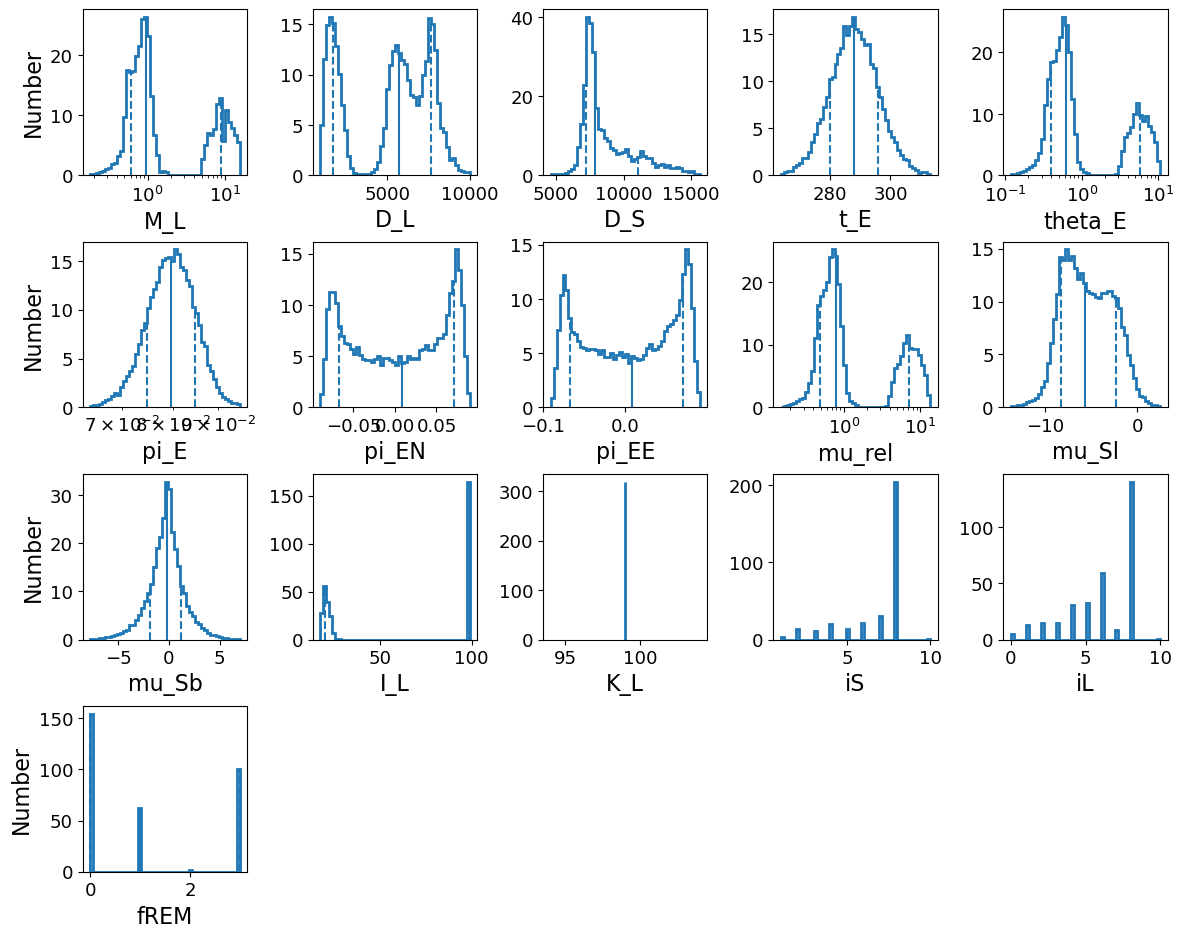

In [29]:
wtcol = 0  # column of wtj, weight for each line
data = print_data(file4, header, DISP = True)
ptiles = hist_wt(data, header, logparams = ['M_L', 'theta_E', 'pi_E', 'mu_rel', 'aL', 'aLpmin'], wtcol = wtcol, PLOT = True, NXBIN = 50) # logparams: header name you want to plot in logscale

In [30]:
print ("Percentiles weighted by ", header[wtcol] , " : ")
print ("#             -2sigma      -1sigma       median      +1sigma      +2sigma")
for i, ptile in enumerate(ptiles):
    if ptile[4] == ptile[0] : continue
    print('{:8s} {:12.5e} {:12.5e} {:12.5e} {:12.5e} {:12.5e}'.format(header[i], ptile[0], ptile[1], ptile[2], ptile[3], ptile[4]))

Percentiles weighted by  wtj  : 
#             -2sigma      -1sigma       median      +1sigma      +2sigma
M_L       3.86119e-01  5.99583e-01  9.48413e-01  8.83251e+00  1.39532e+01
D_L       1.17500e+03  1.71600e+03  5.72800e+03  7.67600e+03  8.64203e+03
D_S       6.56400e+03  7.25000e+03  7.90600e+03  1.10570e+04  1.40660e+04
t_E       2.71908e+02  2.79958e+02  2.87911e+02  2.95750e+02  3.04145e+02
theta_E   2.53597e-01  3.92206e-01  6.15191e-01  5.68692e+00  8.95551e+00
pi_E      6.96406e-02  7.46440e-02  7.96097e-02  8.46448e-02  8.95837e-02
pi_EN    -8.18085e-02 -6.71717e-02  9.03243e-03  7.06929e-02  8.26118e-02
pi_EE    -8.22061e-02 -6.69310e-02  8.05286e-03  7.03095e-02  8.29915e-02
mu_rel    3.21117e-01  4.95903e-01  7.82326e-01  7.22350e+00  1.13684e+01
mu_Sl    -1.01355e+01 -8.24206e+00 -5.62321e+00 -2.33722e+00 -3.00297e-01
mu_Sb    -4.37797e+00 -1.82344e+00 -2.19809e-01  1.21535e+00  3.55155e+00
I_L       1.82734e+01  2.00635e+01  9.90000e+01  9.90000e+01  9.90000e+01
iS   

The flag fREM = 2 indicates a neutron star and fREM = 3 indicates a black hole.
Note that results on a black hole candidate event highly depends on the mass function used. `genulens` calculates the present-day mass function by combining the initial mass function by [Koshimoto, Baba, and Bennett (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...917...78K/abstract) with the initial-final mass relations for compact objects by [Lam et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...31L/abstract).

## Sample 5. Influence of Black Hole Kick Velocity on Microlensing Distributions (added on Mar 2025)
In [Koshimoto, Kawanaka, and Tsuna (2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...973....5K/abstract), we considered the effect of inflating the scale height of the BH population as a function of the BH kick velocity on microlensing distribution.  

In Mar 2025, I implemented the function used for the above study into genulens.

I reproduce here the $v_{\rm avg} = 400~{\rm km/s}$ panel of Fig. 5 and the $v_{\rm avg} = 25~{\rm km/s}$ panel of Fig. 6 of [Koshimoto, Kawanaka, and Tsuna (2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...973....5K/abstract) as an example of the new options.  

For details of the model, please refer to the paper.

### 5.1 The $v_{\rm avg} = 400~{\rm km/s}$ panel of Fig. 4 of [Koshimoto, Kawanaka, and Tsuna (2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...973....5K/abstract)

In [31]:
# Common arguments  
argtxt5 = ''
argtxt5 += ' l -0.14 b -1.62' # coordinate of OGLE-2011-BLG-0462
argtxt5 += ' REMNANT 1' # to simulate BHs
argtxt5 += ' VERBOSITY 3' # control output parameters

# No change in scale height or surface density (same treatment as Koshimoto+21)
argtxt5_0 = argtxt5 + ' vkickBH 400 MXDkick 1 BHhd 0 UseSigBH 0'

# With change in scale height and surface density
argtxt5_1 = argtxt5 + ' vkickBH 400 MXDkick 1 BHhd 1 UseSigBH 1'

print("Sample 5.1 arguments for genulens : ")
print(argtxt5_0)
print(argtxt5_1)

file5_0 = 'sample5_0.dat'
file5_1 = 'sample5_1.dat'

Sample 5.1 arguments for genulens : 
 l -0.14 b -1.62 REMNANT 1 VERBOSITY 3 vkickBH 400 MXDkick 1 BHhd 0 UseSigBH 0
 l -0.14 b -1.62 REMNANT 1 VERBOSITY 3 vkickBH 400 MXDkick 1 BHhd 1 UseSigBH 1


The newly added options are :
- `vkickBH [double]` (default: 100) :
BH kick velocity value in km/sec (see the `MXDkick` description below for what this value is).  


- `MXDkick [0 or 1]` (default: 1) :   
When 1, use Maxwell distribution with the average velocity of $v_{\rm avg} = $ `vkickBH`.  
When 0, use constant kick velocity of $v_{\rm avg} = $ `vkickBH`.  


- `BHhd [0 or 1]` (default: 1):   
When 1, change BH disk scale height following Eq. (5) of [Koshimoto, Kawanaka, and Tsuna (2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...973....5K/abstract).  
When 0, use the stellar disk scale height also for BHs.  


- `UseSigBH [0 or 1]` (default: 1):   
When 1, change BH disk surface density following Eq. (10) of [Koshimoto, Kawanaka, and Tsuna (2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...973....5K/abstract).  
When 0, use the stellar disk surface density also for BHs.  


Note that the modification of the surface density by `UseSigBH` depends on the value of `vkickBH`. However, it is designed to work properly only for the specific values of vkickBH = 25, 50, 100, 200, or 400.  For other values, the surface density adjustment corresponding to the closest one among these five (on a logarithmic scale) is applied.


To make BH population enough to see its distribution, I simulate Nsimu = $3 \times 10^7$ events.  
I also use 'grep 3$' to save the output file size. (BH events have fREM flag = 3, which outputted in the far right with VERBOSITY 3 option.)

In [ ]:
%%time
# run to output BH events
Nsimu = ' Nsimu 3e+7'
header = run_genulens(file5_0, argtxt5_0 + Nsimu, grep = ' 3$')
header = run_genulens(file5_1, argtxt5_1 + Nsimu, grep = ' 3$')

# Conducted command (you can do this directly in your command line too): 

 ./genulens  l -0.14 b -1.62 REMNANT 1 VERBOSITY 3 vkickBH 400 MXDkick 1 BHhd 0 UseSigBH 0 Nsimu 3e+7 |grep  3$ > sample5_0.dat 



In [ ]:
wts0, tEs0, iLs0, fREMs0 = np.loadtxt(file5_0, usecols=[0, 4, 15, 16], unpack=True)
wts1, tEs1, iLs1, fREMs1 = np.loadtxt(file5_1, usecols=[0, 4, 15, 16], unpack=True)

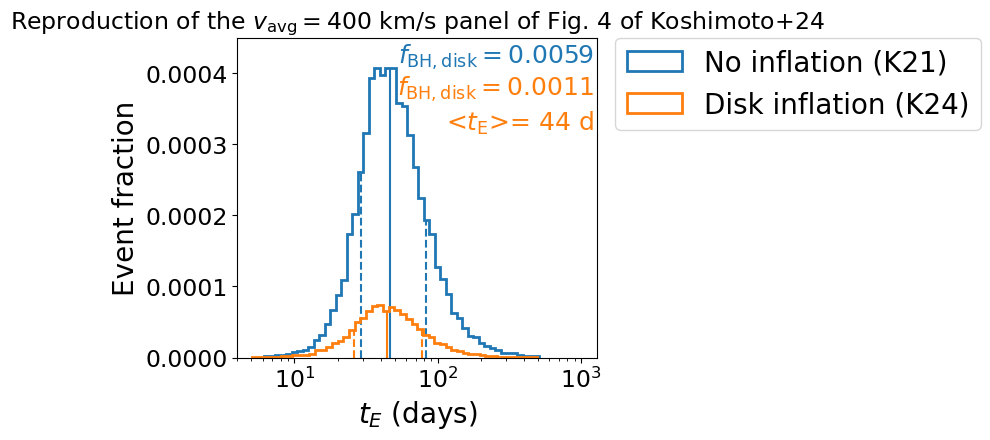

In [ ]:
Nsimu = 3e+7
fig = plt.figure(figsize = (4, 4))
plt.rcParams["font.size"] = 17

xmin, xmax = 4, 1300
ymin, ymax = 0, 4.5e-04
ax1 = fig.add_subplot(111)
tEBH = tEs0[fREMs0 == 3]
wtBH = wts0[fREMs0 == 3]
iLBH = iLs0[fREMs0 == 3] 
col = 'C0'
ll, tEmed0, ul = plot_hist_wt(ax1, tEBH[iLBH < 8], wt = wtBH[iLBH < 8]/Nsimu, log=1,col = col, label = r'No inflation (K21)')
fBHsum = np.sum(wtBH[iLBH < 8]/Nsimu)
ax1.text(xmax*(xmin/xmax)**0.01, ymax - 0.08*(ymax-ymin), r'$f_{\rm BH, disk}=$' + '{:.4f}'.format(fBHsum), 
         fontsize = 18, color= col, horizontalalignment='right')

tEBH = tEs1[fREMs1 == 3]
wtBH = wts1[fREMs1 == 3]
iLBH = iLs1[fREMs1 == 3]
col = 'C1'
ll, tEmed1, ul = plot_hist_wt(ax1, tEBH[iLBH < 8], wt = wtBH[iLBH < 8]/Nsimu, log=1,col = col, label = r'Disk inflation (K24)')
fBHsum = np.sum(wtBH[iLBH < 8]/Nsimu)
ax1.text(xmax*(xmin/xmax)**0.01, ymax - 0.18*(ymax-ymin), r'$f_{\rm BH, disk}=$' + '{:.4f}'.format(fBHsum), 
         fontsize = 18, color= col, horizontalalignment='right')
ax1.text(xmax*(xmin/xmax)**0.01, ymax - 0.29*(ymax-ymin), r'<$t_{\rm E}$>'+'= {:.0f} d'.format(tEmed1), 
         fontsize = 18, color= col, horizontalalignment='right')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax1.set_xlabel(r'$t_E$ (days)', fontsize = 20)
ax1.set_title(r'Reproduction of the $v_{\rm avg}=$' + '400 km/s panel of Fig. 4 of Koshimoto+24', fontsize = 17)
ax1.set_ylabel(r'Event fraction', fontsize = 20)
ax1.legend(fontsize = 20, loc='upper left', bbox_to_anchor=(1.05, 1.00), borderaxespad=0)

fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, hspace = 0.25, wspace = 0.3)


### 5.2 The $v_{\rm avg} = 25~{\rm km/s}$ panel of Fig. 6 of [Koshimoto, Kawanaka, and Tsuna (2024)](https://ui.adsabs.harvard.edu/abs/2024ApJ...973....5K/abstract)

In [ ]:
# Set v_avg = 25 km/s and add NoGAMMAIS option
argtxt5_2 = argtxt5 + ' vkickBH 25 NoGAMMAIS 1'

print("Sample 5.2 arguments for genulens : ")
print(argtxt5_2)

file5_2 = 'sample5_2.dat'

Sample 5.2 arguments for genulens : 
 l -0.14 b -1.62 REMNANT 1 VERBOSITY 3 vkickBH 25 NoGAMMAIS 1


This time I intentionally omitted MXDkick, BHhd, and UseSigBH from the input arguments because their default value is 1.  
I added the `NoGAMMAIS 1` option to make wtj closer to 1 since plt.scatter does not accept an weight list.

In [ ]:
%%time
# run to output BH events
Nsimu = ' Nsimu 2e+5'
header = run_genulens(file5_2, argtxt5_2 + Nsimu)

# Conducted command (you can do this directly in your command line too): 

 ./genulens  l -0.14 b -1.62 REMNANT 1 VERBOSITY 3 vkickBH 25 NoGAMMAIS 1 Nsimu 2e+5 > sample5_2.dat 

CPU times: user 1.55 ms, sys: 8.42 ms, total: 9.98 ms
Wall time: 1.31 s


In [ ]:
tEs, piEs, fREMs = np.loadtxt(file5_2, usecols=[4, 6, 16], unpack=True)

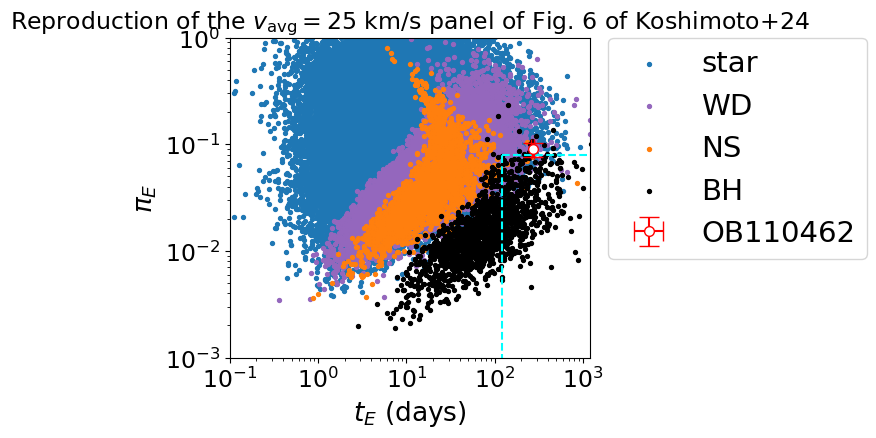

In [ ]:
fig = plt.figure(figsize = (4, 4))
cols = ['C0', 'C4', 'C1', 'black']
labels = ['star', 'WD', 'NS', 'BH']
tEobs = 270.7
tEe = 11.2
piEobs = 0.0894
piEe = 0.0135
l_tick_mi = 4
l_tick_ma = 8

ax1 = fig.add_subplot(111)
for iRem in range(4):
    indices = np.where(fREMs == iRem)
    ax1.scatter(tEs[indices], piEs[indices], c = cols[iRem], s = 8, label = labels[iRem])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$t_E$ (days)', fontsize = 19)
ax1.set_ylabel(r'$\pi_E$', fontsize = 19)
ax1.set_xlim(0.1, 1200)
ax1.set_ylim(0.001, 1.0)
ax1.set_title(r'Reproduction of the $v_{\rm avg}=$' + '25 km/s panel of Fig. 6 of Koshimoto+24', fontsize = 17)
ax1.errorbar(tEobs, piEobs, xerr= tEe, yerr= piEe, 
                    capsize= 7, fmt='o', markersize=7, ecolor='red', markeredgecolor = "red", color='w', label = 'OB110462')
ax1.legend(fontsize = 21, loc='upper left', bbox_to_anchor=(1.05, 1.00), borderaxespad=0)
# Lam+20's threshold of (tE, piE) = (120, 0.08)
ax1.vlines(120, 0, 0.08, ls = '--', color = 'cyan')
ax1.hlines(0.08, 120, 10000, ls = '--', color = 'cyan')

fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, hspace = 0.3, wspace = 0.3)

## Remove the output files if you want

In [ ]:
# Do not do these cells if you want to keep sample1.dat, sample2.dat, sample3.dat, or sample4.dat
# Remove sample1.dat
try: 
    os.remove(file1)
except FileNotFoundError: 
    pass

In [ ]:
# Remove sample2.dat
try: 
    os.remove(file2)
except FileNotFoundError: 
    pass

In [ ]:
# Remove sample3.dat
try: 
    os.remove(file3)
except FileNotFoundError: 
    pass

In [ ]:
# Remove sample4.dat
try: 
    os.remove(file4)
except FileNotFoundError: 
    pass

In [ ]:
# Remove files made in Sample 5
files = [file5_0, file5_1, file5_2]
for file in files:
    try: 
        os.remove(file)
    except FileNotFoundError: 
        pass